In [95]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')
from flair.data import Sentence
from flair.nn import Classifier

### Data preparation and initial visualisation

In [2]:
df = pd.read_csv("singapore_airlines_reviews.csv", parse_dates=['published_date'])
df

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12 14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11 19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11 12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11 07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10 05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0
...,...,...,...,...,...,...,...
9995,2018-08-06 03:48:21-04:00,Desktop,5,review,First part done with Singapore Airlines - acce...,"Flew to NZ 1st half Singapore Airlines, 2nd ha...",1
9996,2018-08-05 22:50:29-04:00,Mobile,5,review,And again a great Flight with Singapore Air. G...,Best Airline,1
9997,2018-08-05 22:47:06-04:00,Desktop,5,review,"We flew business class from Frankfurt, via Sin...",Superb service on Singapore Airlines,1
9998,2018-08-05 20:32:03-04:00,Desktop,4,review,"As always, the A380 aircraft was spotlessly pr...",A Comfortable Fiight Spoiled by lack of adequa...,2


In [3]:
df['published_date'] = pd.to_datetime(df['published_date'], utc=True)

In [4]:
df.head(5)

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12 18:41:14+00:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11 23:39:13+00:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11 16:20:23+00:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11 11:12:27+00:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10 09:34:18+00:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


In [5]:
df.dtypes

published_date        datetime64[ns, UTC]
published_platform                 object
rating                              int64
type                               object
text                               object
title                              object
helpful_votes                       int64
dtype: object

In [6]:
df['published_hour'] = df['published_date'].dt.hour

Text(0.5, 1.0, 'Average rating per month')

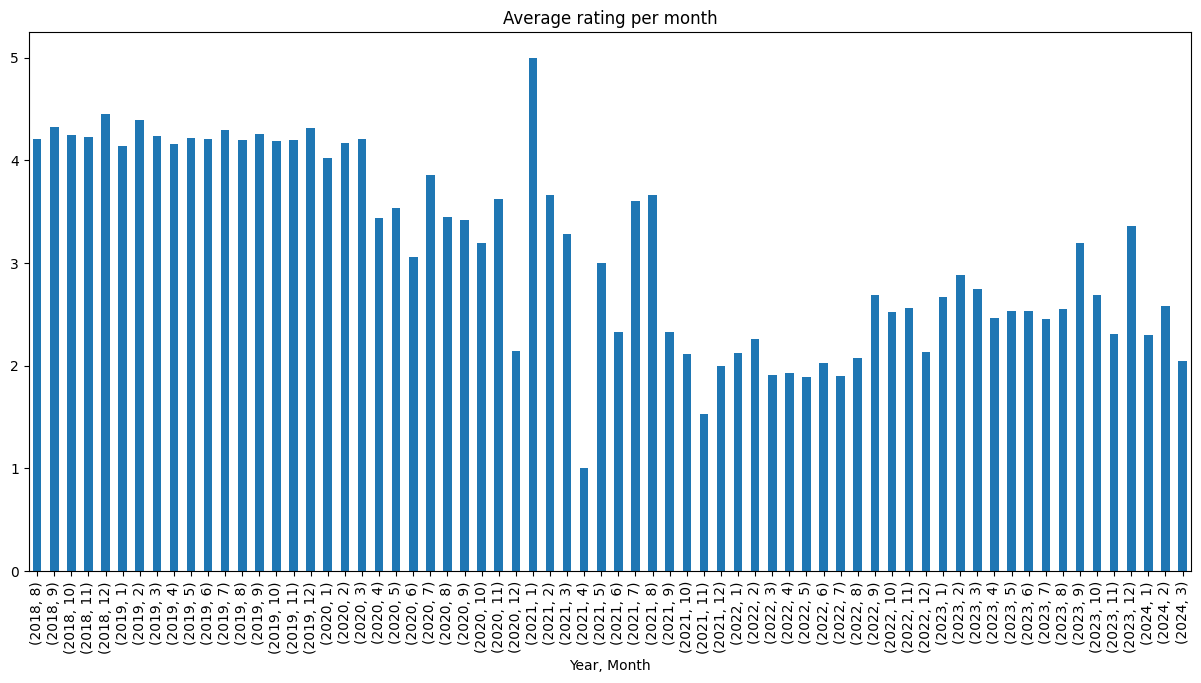

In [7]:
df.groupby([df['published_date'].dt.year, df['published_date'].dt.month])['rating'].mean().plot(kind='bar', figsize=(15, 7))
plt.xlabel('Year, Month')
plt.title('Average rating per month')

Text(0.5, 1.0, 'Number of ratings per month')

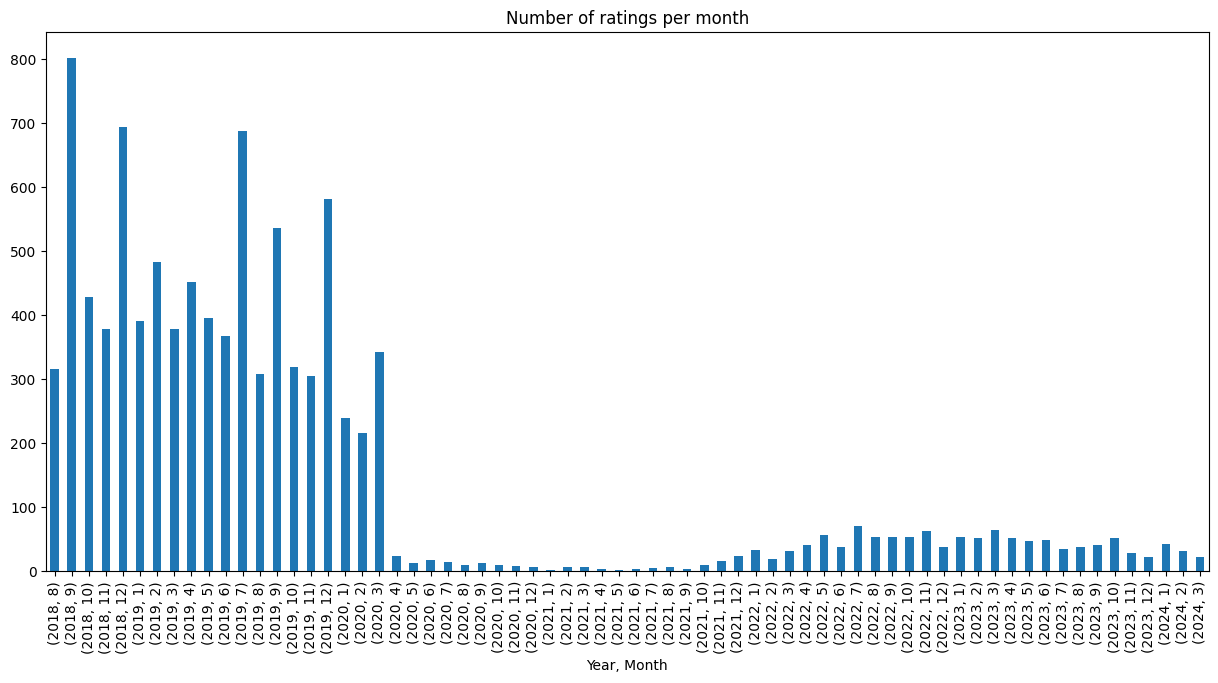

In [8]:
df.groupby([df['published_date'].dt.year, df['published_date'].dt.month])['rating'].count().plot(kind='bar', figsize=(15, 7))
plt.xlabel('Year, Month')
plt.title('Number of ratings per month')

In [9]:
df[(df['published_date'].dt.year == 2021) & (df['published_date'].dt.month == 4)]


,published_date,published_platform,rating,type,text,title,helpful_votes,published_hour
1249,2021-04-30 19:11:29+00:00,Desktop,1,review,So we originally booked to go to Japan for Che...,Worse customer service,3,19
1250,2021-04-29 04:46:05+00:00,Mobile,1,review,Singapore Airlines recently advised they had r...,Ineffective administration,3,4
1251,2021-04-26 09:10:50+00:00,Desktop,1,review,"Never recommend to use this airline, poor cus...",Bad customer during the covid,3,9
1252,2021-04-09 04:31:43+00:00,Desktop,1,review,Choose any other airline than Singapore Airlin...,Would not recommend,2,4


In [10]:
df = df.drop('type', axis=1)

In [11]:
df.head(5)

,published_date,published_platform,rating,text,title,helpful_votes,published_hour
0,2024-03-12 18:41:14+00:00,Desktop,3,We used this airline to go from Singapore to L...,Ok,0,18
1,2024-03-11 23:39:13+00:00,Desktop,5,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,23
2,2024-03-11 16:20:23+00:00,Desktop,1,"Booked, paid and received email confirmation f...",Don’t give them your money,0,16
3,2024-03-11 11:12:27+00:00,Desktop,5,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,11
4,2024-03-10 09:34:18+00:00,Desktop,2,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,9


In [12]:
df['helpful_votes'].value_counts().sort_index()

helpful_votes
0      3091
1      3493
2      2481
3       564
4       190
5        77
6        38
7        17
8        10
9         8
10        7
11        3
12        4
17        1
21        2
24        1
25        1
27        3
29        1
35        1
41        1
43        1
56        1
61        1
90        1
108       1
158       1
Name: count, dtype: int64

<Axes: xlabel='published_hour'>

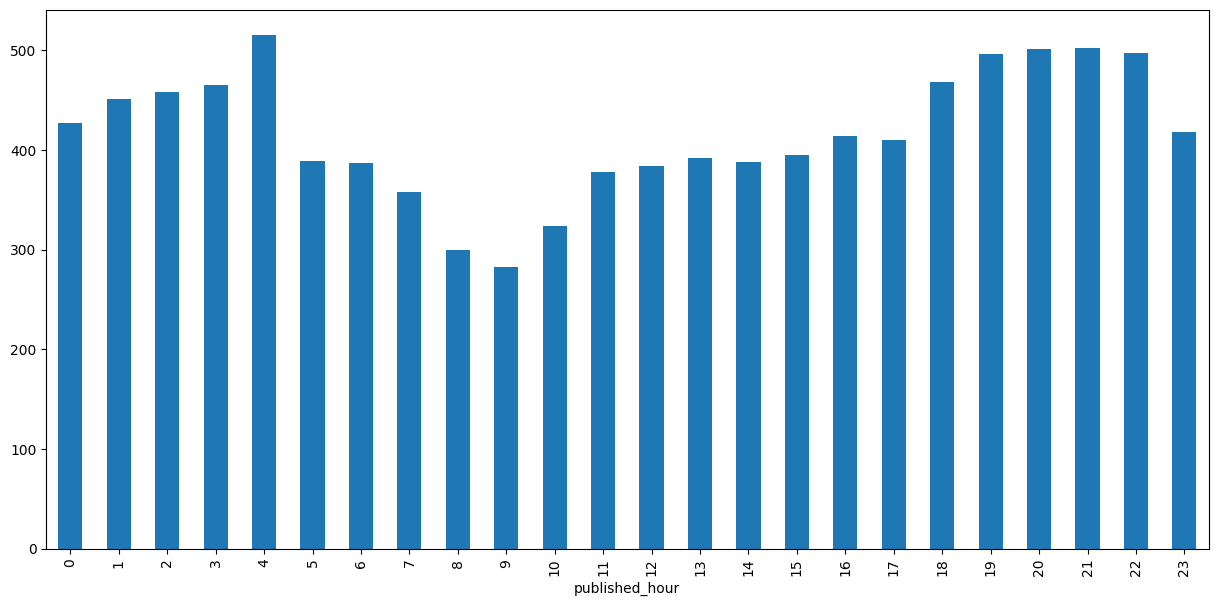

In [13]:
df['published_hour'].value_counts().sort_index().plot(kind='bar', figsize=(15, 7))

<Axes: xlabel='helpful_votes'>

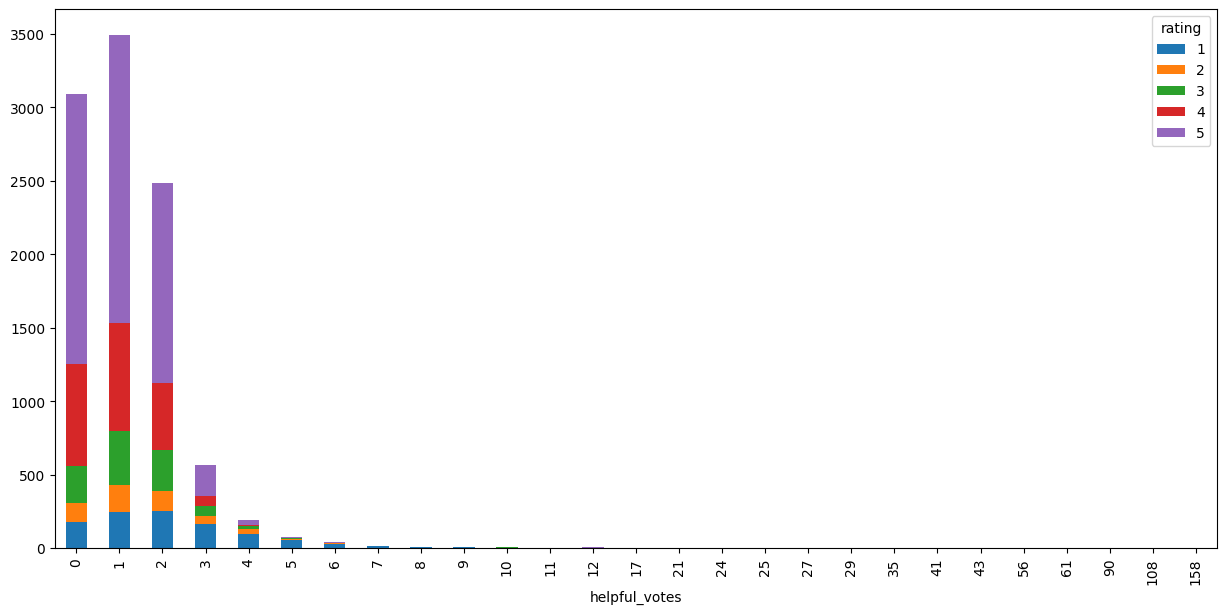

In [14]:
pd.crosstab(df['helpful_votes'], df['rating']).plot(kind='bar', stacked=True, figsize=(15, 7))

In [15]:
df['published_platform'].value_counts()

published_platform
Desktop    7352
Mobile     2648
Name: count, dtype: int64

<Axes: xlabel='published_platform'>

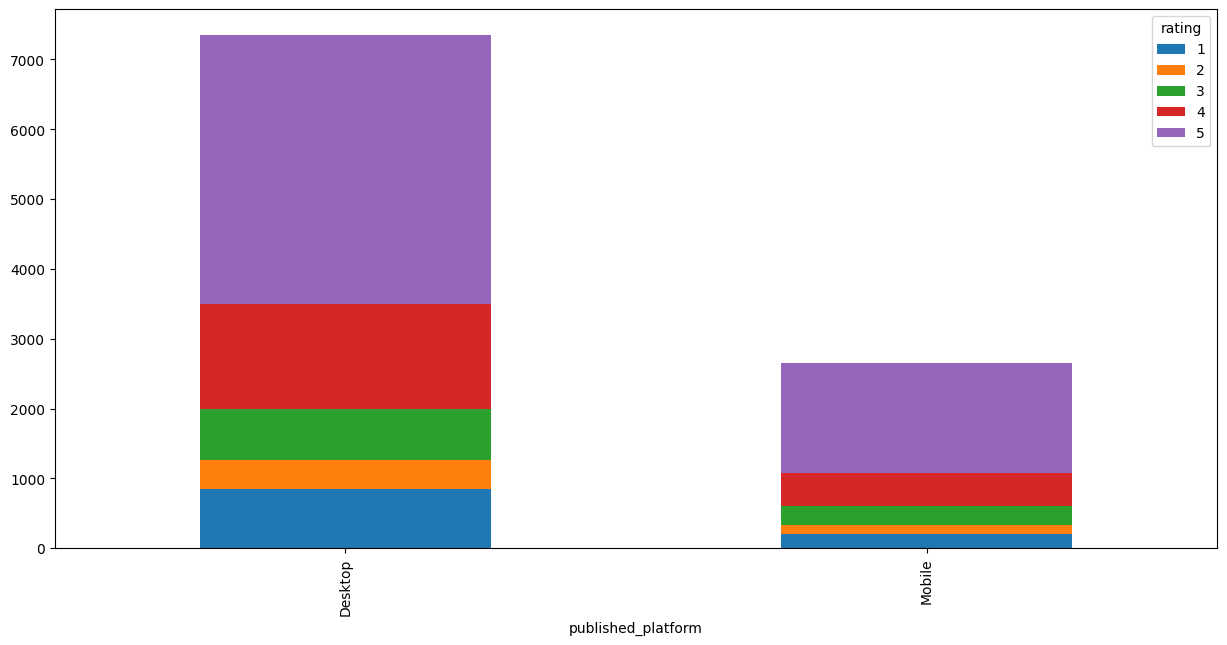

In [16]:
pd.crosstab(df['published_platform'], df['rating']).plot(kind='bar', stacked=True, figsize=(15, 7))

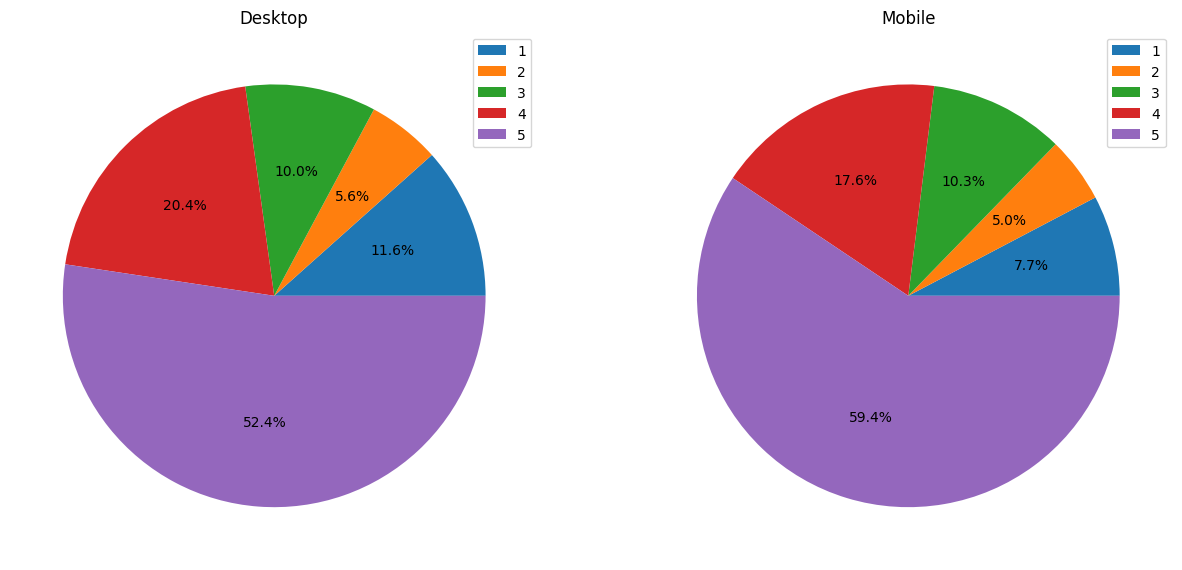

In [17]:
plt.figure(figsize=(15, 10))
i = 1
for value in df['published_platform'].unique():
    plt.subplot(1, 2, i)
    df[df['published_platform']==value].groupby('rating').count()['text'].plot(kind='pie', autopct='%1.1f%%', labeldistance=None)
    plt.legend()
    plt.ylabel('')
    plt.title(value)
    i += 1

In [18]:
df['published_on_desktop'] = df['published_platform'].apply(lambda x: 1 if x=='Desktop' else 0)
df = df.drop('published_platform', axis=1)

In [19]:
df.head(5)

,published_date,rating,text,title,helpful_votes,published_hour,published_on_desktop
0,2024-03-12 18:41:14+00:00,3,We used this airline to go from Singapore to L...,Ok,0,18,1
1,2024-03-11 23:39:13+00:00,5,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,23,1
2,2024-03-11 16:20:23+00:00,1,"Booked, paid and received email confirmation f...",Don’t give them your money,0,16,1
3,2024-03-11 11:12:27+00:00,5,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,11,1
4,2024-03-10 09:34:18+00:00,2,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,9,1


<Axes: >

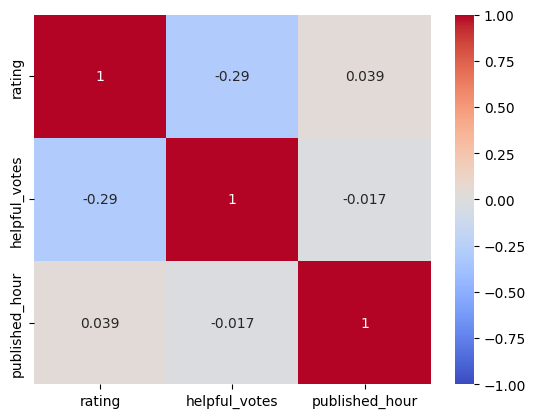

In [20]:
sns.heatmap(df[['rating', 'helpful_votes', 'published_hour']][df['helpful_votes']<10].corr(), annot=True, vmin=-1, vmax=1, center=0, cmap='coolwarm')

### Sentiment analysis

#### 1. Using nltk vader

In [33]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(df['text'][0])

{'neg': 0.019, 'neu': 0.871, 'pos': 0.109, 'compound': 0.9781}

In [29]:
df['compound_vader'] = df['text'].apply(lambda review: sid.polarity_scores(review)['compound'])

In [36]:
df['compound_vader'].describe()

count    10000.000000
mean         0.564201
std          0.605408
min         -0.998100
25%          0.476700
50%          0.875000
75%          0.953400
max          0.999900
Name: compound_vader, dtype: float64

Text(0, 0.5, '')

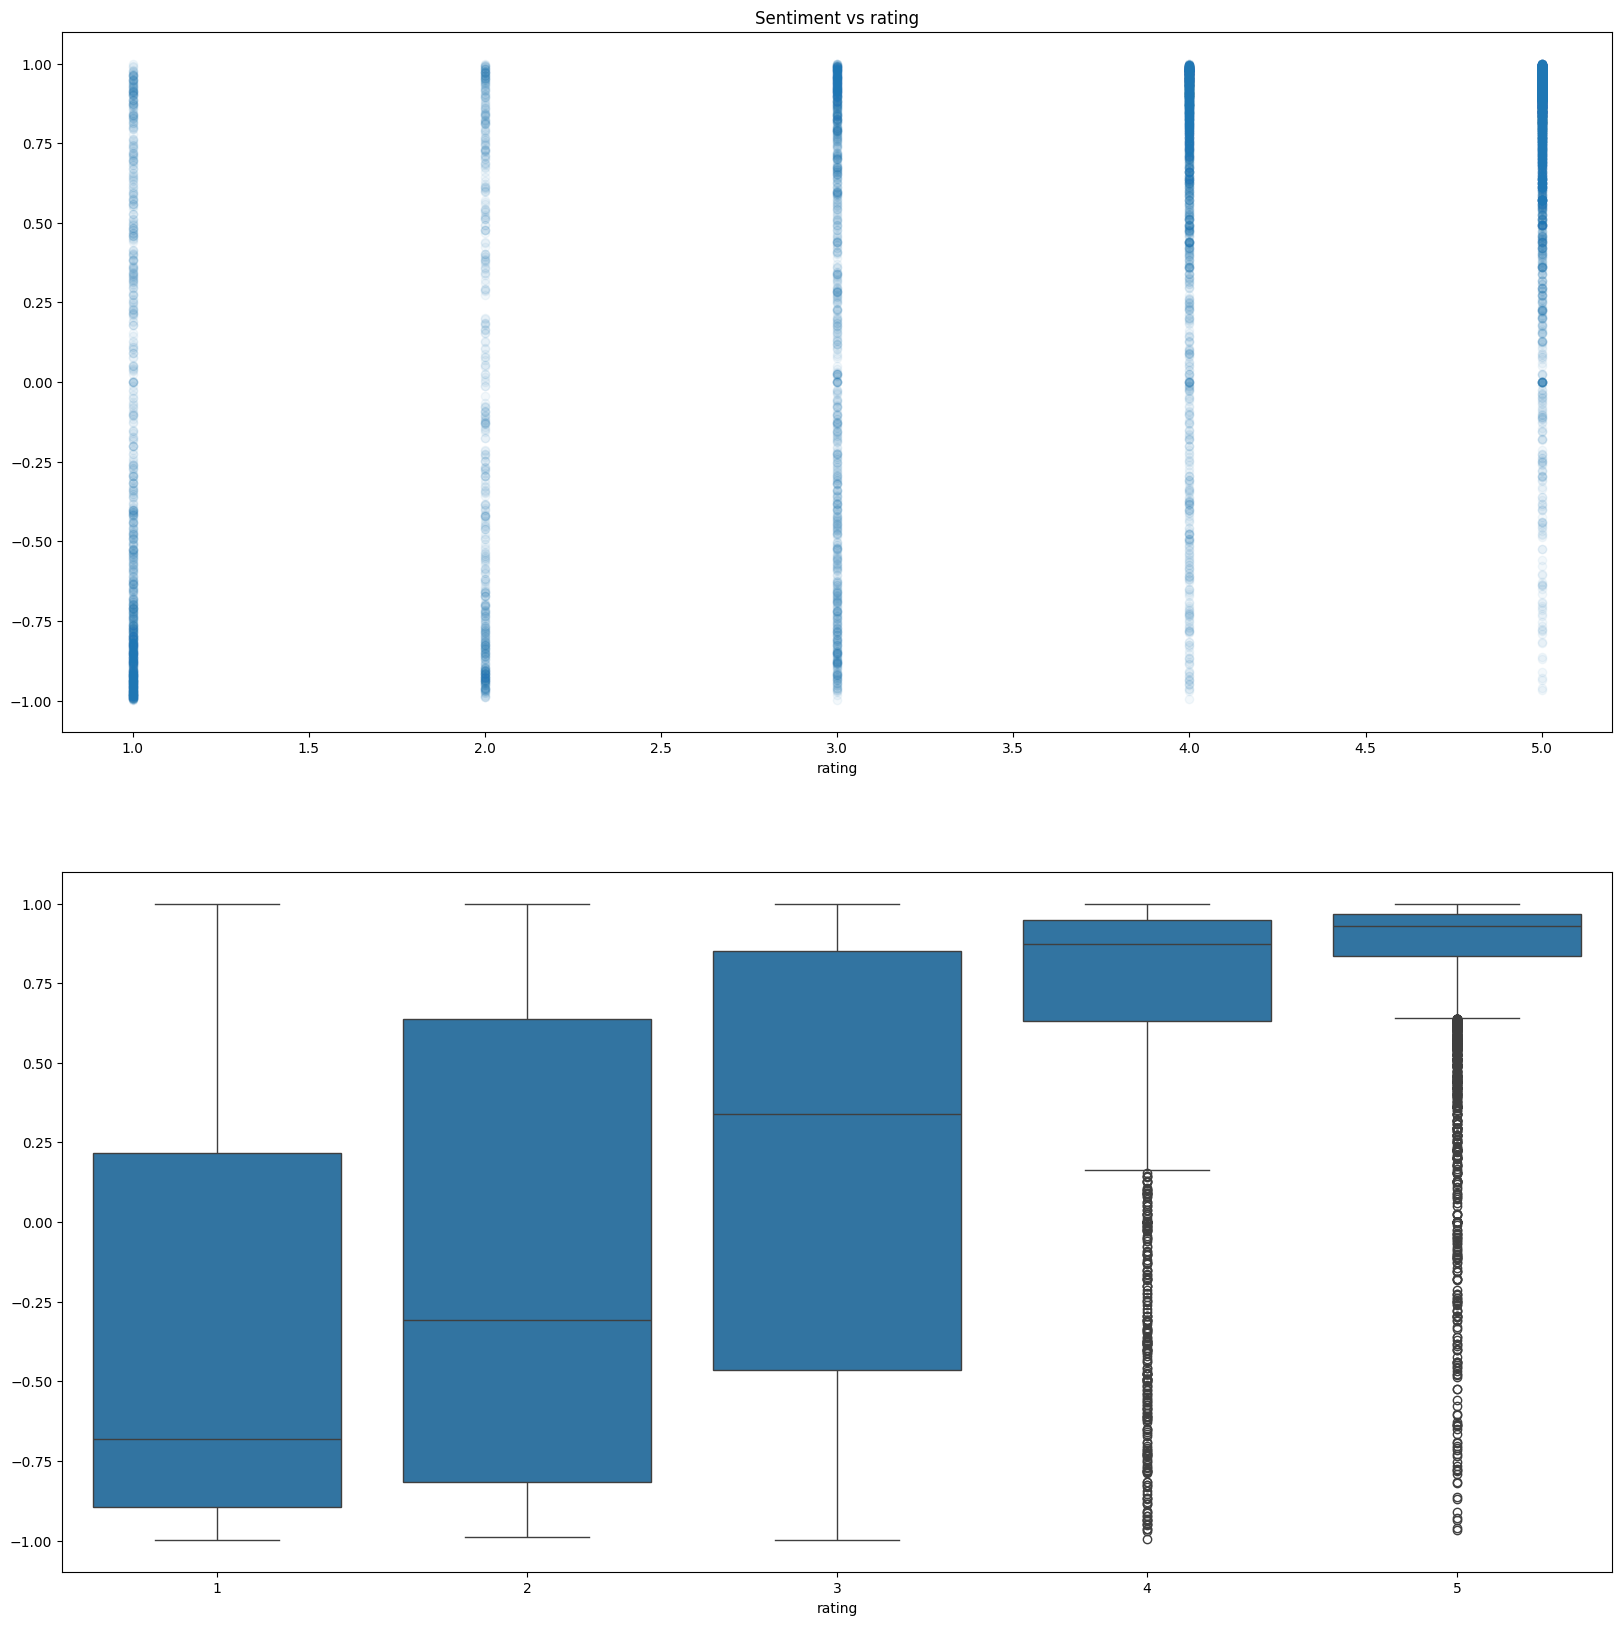

In [56]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.scatter(x=df['rating'], y=df['compound_vader'], alpha=0.05)
plt.xlabel('rating')
plt.title('Sentiment vs rating')
plt.subplot(2, 1, 2)
sns.boxplot(data=df, x='rating', y='compound_vader')
plt.ylabel('')

In [62]:
df.groupby('rating').agg(
    Mean=('compound_vader', 'mean'),
    Std=('compound_vader', 'std')
)

,Mean,Std
rating,,
1,-0.360280,0.653775
2,-0.126755,0.714701
3,0.190672,0.679469
4,0.678318,0.447054
5,0.841632,0.247366


In [92]:
rows_for_check = df[(df['compound_vader']<-0.5) & (df['rating']==5)].index
for index in random.choices(rows_for_check, k=5):
    print(f"row number {index}, score: {df['compound_vader'][index]}")
    print(f"{df['text'][index]}")

row number 8095, score: -0.9091
The plane and the service were very good we travelled in seats 32H and J on one leg and were moved to 31 Hand J because the headphones weren't working on our booked seats and the extra space made a lot of difference but I find it hard to comprehend why after paying for premium you have to pay extra for the bulkhead seats which sit empty. Singapore airlines need to get someone to book on premium economy on Air New Zealand or Cathay Pacific as their premium economy service food and service leaves Singapore for dead. I believe that the price you pay is between economy and business class and the food and service should reflect this which is what it is on the other two airlines but sadly not on Singapore. We have travelled on the other airlines in the last 12 months
row number 9966, score: -0.7094
Polite and attentive service ,  Business class chairs are not so comfortable when one has to lay diagonally.  Too much bedding to handle and once opened is difficul